#### Supervised classification using the  Wine dataset

#### Load the data, inspect and split it

In [1]:
# Force matplotlib inline backend
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import datasets
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

from scipy.stats import randint, uniform

In [2]:
# load the training dataset
wine = datasets.load_wine(as_frame=True)

# load the truth labels
X = pd.DataFrame(data=wine.data)
y = data=wine.target

Always check if the data needs processing to even begin the classification work

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [6]:
# split the data
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#### Use XGBoost classifier for classification

We'll use a very simple XGBoost classifier. We'll optimize the hyperparameters though so that we get the best accuracy that we can.

In [7]:
%%time

# parameter distributions
param_distributions = {
    'max_depth': randint(3, 10),           # Tree depth
    'learning_rate': uniform(0.01, 0.3),   # Learning rate (eta)
    'n_estimators': randint(50, 300),      # Number of trees
    'min_child_weight': randint(1, 7),     # Minimum sum of instance weight
    'subsample': uniform(0.6, 0.4),        # Fraction of samples per tree (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4), # Fraction of features per tree (0.6-1.0)
    'gamma': uniform(0, 0.5),              # Minimum loss reduction
    'reg_alpha': uniform(0, 1),            # L1 regularization
    'reg_lambda': uniform(1, 2)            # L2 regularization
}

# Create the base model
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(wine.target_names),
    eval_metric='mlogloss',
    random_state=42
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    n_iter=50,              # Number of random combinations to try
    scoring='accuracy',     # Scoring metric, accuracy is fine
    cv=5,                   # 5-fold cross-validation
    verbose=1,              # Print progress
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

# Fit the random search
print("Starting hyperparameter optimization...")
random_search.fit(X_train, y_train)

# Get the best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.4f}")

# Use the best model
best_model = random_search.best_estimator_

# Evaluate on test set
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score:.2f}")

Starting hyperparameter optimization...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:
{'colsample_bytree': np.float64(0.6072301454462083), 'gamma': np.float64(0.2469468575917173), 'learning_rate': np.float64(0.06364681276639864), 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 194, 'reg_alpha': np.float64(0.3080607918523892), 'reg_lambda': np.float64(2.085080461109799), 'subsample': np.float64(0.803525630735504)}

Best cross-validation score: 0.9788
Test set score: 1.00
CPU times: total: 1.62 s
Wall time: 7.6 s


Hyperparameters look great, and model is trained!

If you were testing the model against some other test data, you would do what is shown below but with some other `y_test` dataset. We use the same `y_test` to illustrate this point.

In [8]:
# Initialize the XGBoost Classifier
# We use 'XGBClassifier' for classification tasks
model = xgb.XGBClassifier(**random_search.best_params_, num_class=len(wine.target_names), eval_metric='mlogloss')

In [9]:
# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6072301454462083), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.2469468575917173), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.06364681276639864), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=194, n_jobs=None, num_class=3, ...)

In [10]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print('')


Accuracy: 1.00



In [11]:
results_df = pd.DataFrame({'Test_set':y_test.values, 'Predictions':y_pred})

results_df.head()

,Test_set,Predictions
0,0,0
1,0,0
2,2,2
3,0,0
4,1,1


In [12]:
# We classified everything correctly...right?

mismatched_idx = results_df[results_df['Test_set'] != results_df['Predictions']]
mismatched_idx

,Test_set,Predictions


Yes!

#### Let's check some feature importances.

Checking feature importances is very important to understand your data.

In [13]:
# create the feature and importance dataframes for plotting
labels_df = pd.DataFrame(model.feature_names_in_,columns=['feature'])
importances_df = pd.DataFrame(model.feature_importances_,columns=['importance'])

# Combine the two DataFrames
combined_df = pd.concat([labels_df, importances_df], axis=1)

# Sort the data by importance metric
combined_df = combined_df.sort_values(by='importance', ascending=False)

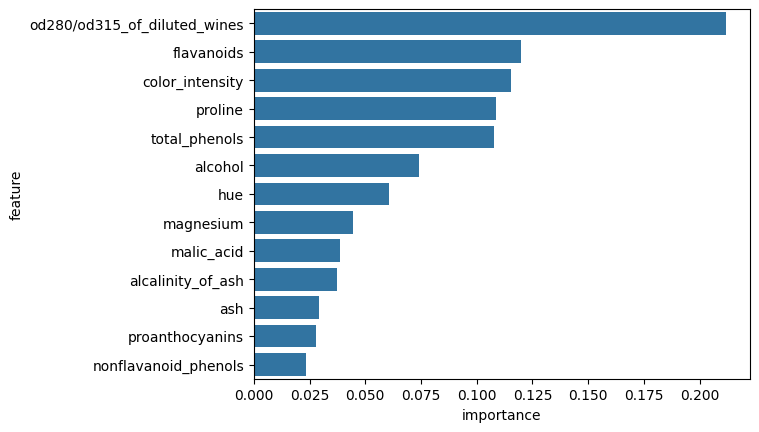

In [14]:
import seaborn as sns
# let's plot the feature importances
sns.barplot(x='importance', y='feature', data=combined_df)
plt.show()

Permutation Importance

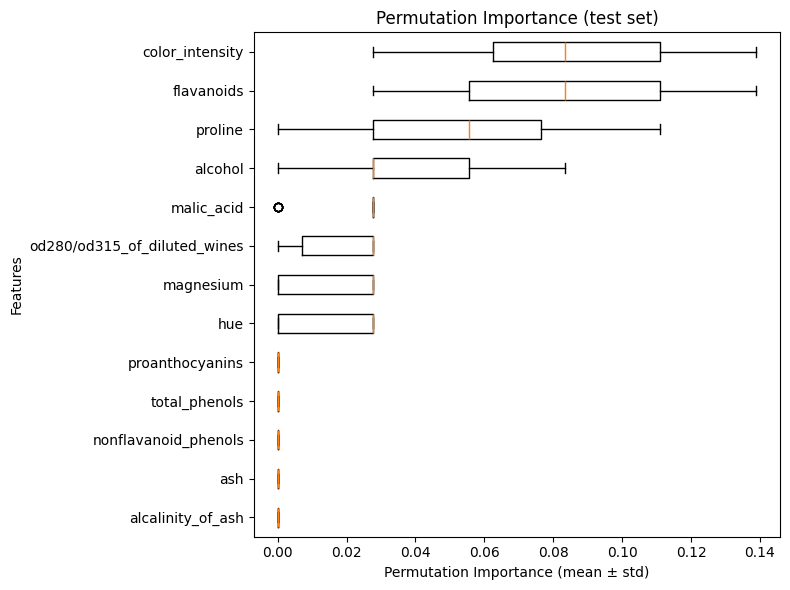

In [15]:
# import permutation importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model.fit(X_train, y_train), X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance (test set)")
ax.set_xlabel("Permutation Importance (mean ± std)")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

Another metric - SHAP values.

In [16]:
%%time

import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

CPU times: total: 891 ms
Wall time: 715 ms


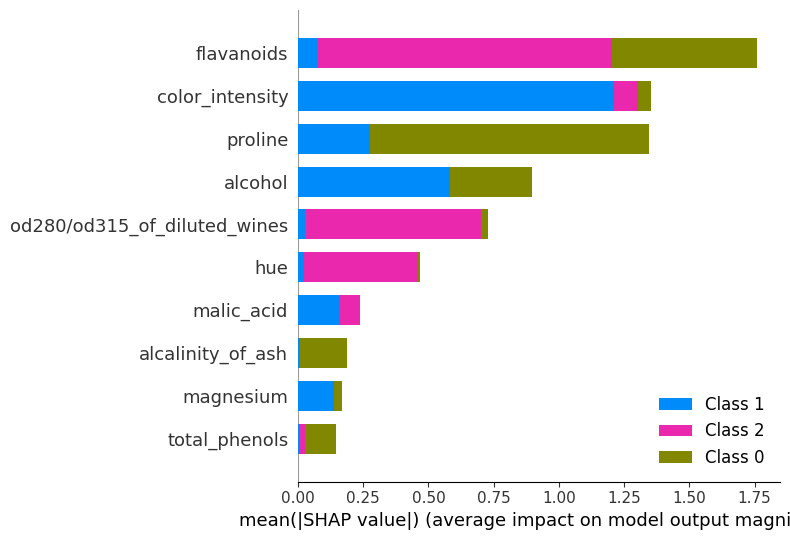

In [17]:
# summary plot - bar
shap.summary_plot(
    shap_values,  # all the classes
    X_test,
    plot_type="bar",
    max_display=10
)

This is really nice. It shows that same features had more or less of an impact depending on what class we were focused on.

The same data as above can be represented as separate violin plots below

In [18]:
# we know there are three classifications.
print("shap_values shape:", shap_values.shape)

shap_values shape: (36, 13, 3)


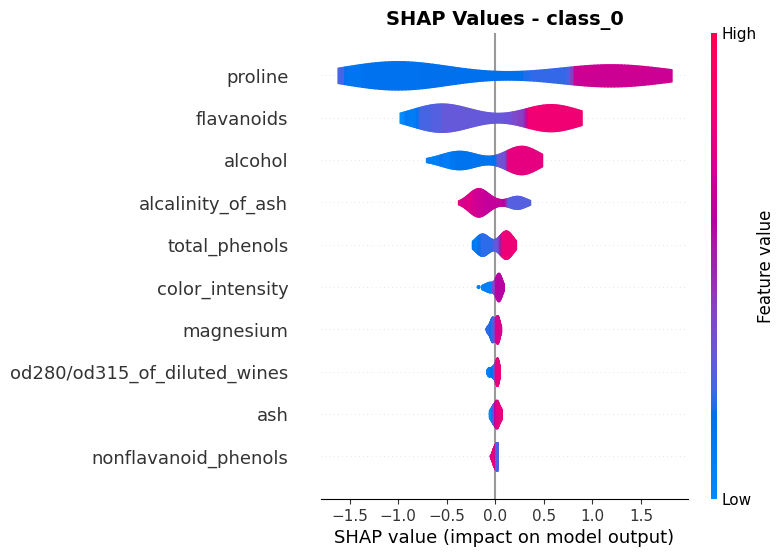

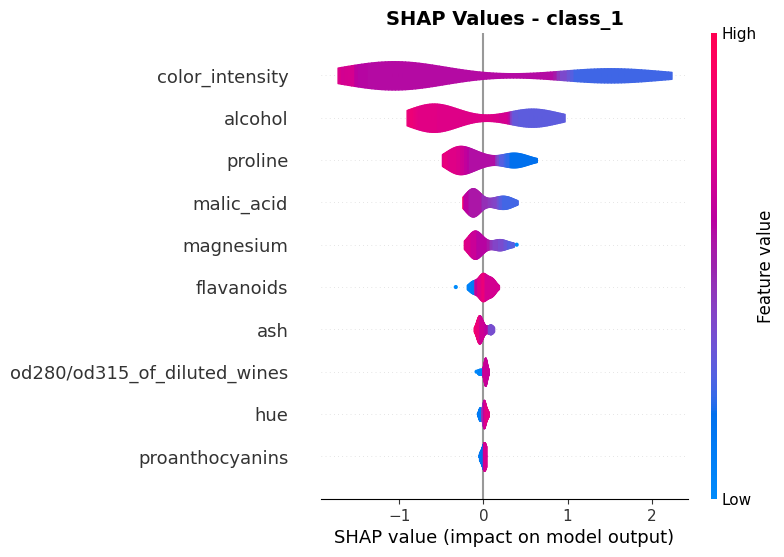

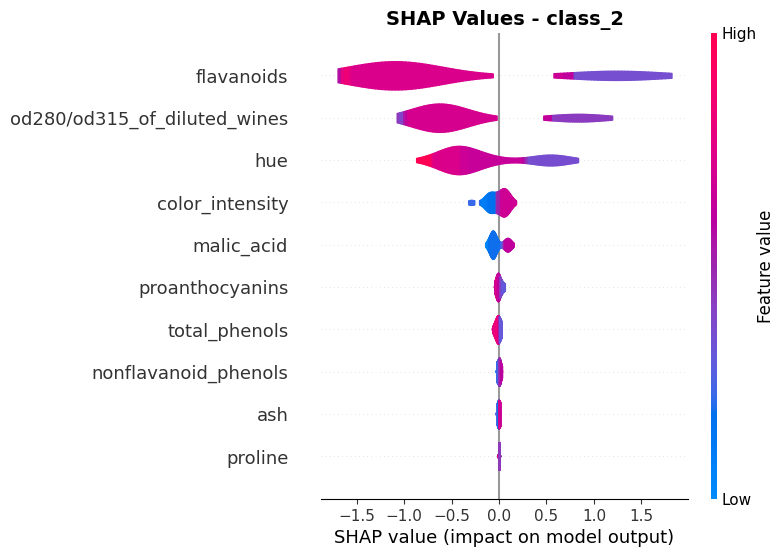

In [19]:
# Plot for each wine class separately
for i, class_name in enumerate(wine.target_names):
    plt.figure(figsize=(6, 8))
    shap.summary_plot(
        shap_values[:, :, i],  # Select class i where i=[0,1,2]
        X_test,
        plot_type="violin",
        max_display=10,
        show=False
    )
    plt.title(f'SHAP Values - {class_name}', fontsize=14, fontweight='bold')
    plt.show()

Awesome!

Now, we will use these important features and try unsupervised learning approach and see if I can perfectly cluster the data. I also used all the features to cluster and probably should not have done that anyway....